# Calculating the Quantum Yield with the Integrating Sphere

In [13]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rootpy
import scipy

import PTI.ReadDataFiles
reload(PTI.ReadDataFiles)
from PTI.ReadDataFiles import PTIData
import PTI.SpectraFitting as spec_fit

## II. Determining the Effect of Emission Correction

In [25]:
'''Interpolates between two points by taking the average of them. Returns an array twice the size'''
def interpolate_with_avg(array):
    return np.append(np.dstack((array[:-1], array[:-1] + np.diff(array)/2)).ravel(), array[-1])

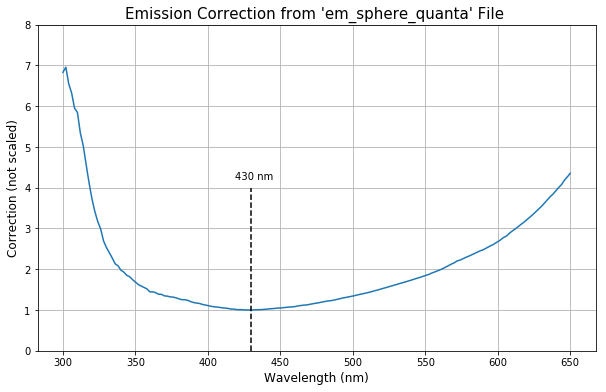

In [46]:
# Import emission correction files
emcorr_quanta_sphere_wavelengths = np.arange(300,848,0.5)
emcorr_quanta_sphere_values = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta_0x5_nm_step.txt")

start_wavelength = 300
end_wavelength = 650
desired_wavelengths = np.where((emcorr_quanta_sphere_wavelengths >= start_wavelength) & 
                               (emcorr_quanta_sphere_wavelengths <= end_wavelength))

emcorr_quanta_sphere_values = emcorr_quanta_sphere_values[desired_wavelengths]

figure = plt.figure(figsize=(10,6))
plt.plot(emcorr_quanta_sphere_wavelengths[desired_wavelengths],emcorr_quanta_sphere_values)
plt.title("Emission Correction from 'em_sphere_quanta' File ",fontsize=15)
plt.xlabel("Wavelength (nm)",fontsize=12)
plt.ylabel("Correction (not scaled)",fontsize=12)
plt.ylim([0,8])
plt.grid()

plt.axvline(x=430, ymax=0.5, color='k', linestyle='--')
plt.text(419, 4.2,"430 nm")

plt.show()

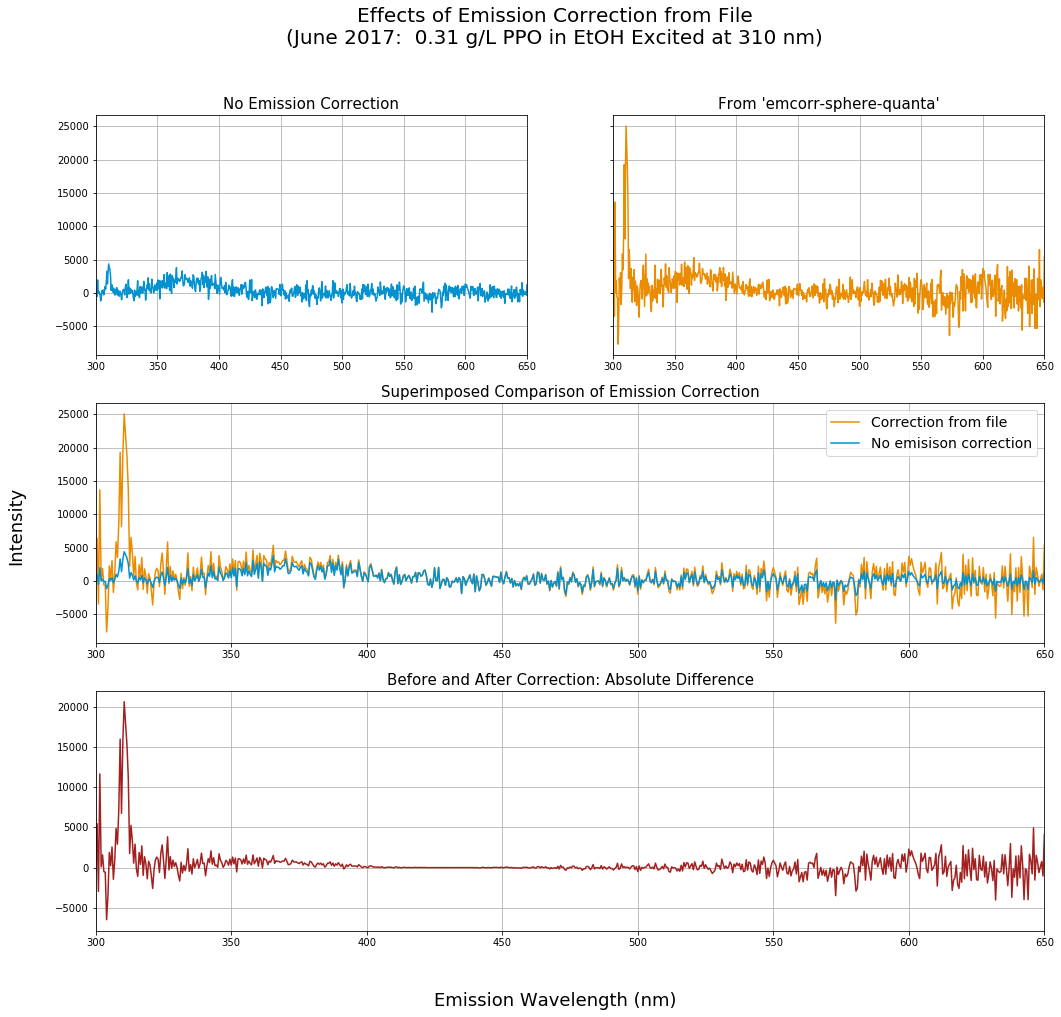

In [47]:
path = "Noah/Integrating Sphere Tests for PPO Contamination/"
test_data = PTIData(path + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt")

wavelength_ranges = [[440,650]]

# Baseline subtract with a simple tail-end, linear fit
no_emcor = spec_fit.get_linear_subtracted(test_data, 1, wavelength_ranges)
emcor = np.multiply(no_emcor,emcorr_quanta_sphere_values)


fig = plt.figure(figsize=(17,15))
fig.suptitle("Effects of Emission Correction from File\n"+
             "(June 2017:  0.31 g/L PPO in EtOH Excited at 310 nm)",fontsize=20)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=18)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=18)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1),sharey = ax1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2,sharex=ax3)

ax1.plot(test_data.wavelengths, no_emcor, "#0392cf")
ax1.set_title("No Emission Correction", fontsize=15)

ax2.plot(test_data.wavelengths, emcor,"#eb8c00")
ax2.set_title("From 'emcorr-sphere-quanta'", fontsize=15)
plt.setp(ax2.get_yticklabels(), visible=False)

ax3.plot(test_data.wavelengths, emcor,"#eb8c00")

ax3.plot(test_data.wavelengths, no_emcor, "#0392cf")
ax3.legend(["Correction from file","No emisison correction"], fontsize=14)
ax3.set_title("Superimposed Comparison of Emission Correction", fontsize=15)

ax4.plot(test_data.wavelengths, emcor-no_emcor, '#a32020')
ax4.set_title("\n\nBefore and After Correction: Absolute Difference", fontsize=15)

for ax in [ax1, ax2,ax3,ax4]:
    ax.grid()
    ax.set_xlim([300,650])

plt.show()

**Conclusion**: As we expect, the correction has a larger effect on shorter wavelengths and reaches a minimum at about 430 nm. After this point, however, the correction increases again. Hence, our results agree with the expected effects. To calculate the quantum yield of our samples, we will manually apply the emission correction from 'emcorr-quantum-sphere'.

## III. Calcuting the Quantum Yield 

In order to determine whether we can use the contaminated Integrating Sphere to analyze the QY of WbLS, we can compare measurements taken in August and June. Hopefully, their calculated QY will be similiar so that the contamination of the sphere is negligible for our purposes. 

In [5]:
def calc_QY(pti_blank_data, pti_fluor_data, 
           ex_integration_range, em_integration_range,
           ranges_for_baseline = [[450,650]],
           em_correction_array=None,
           emcorr_local_file_correction = True):
    
    # Baseline subtract with linear fit
    b_data = spec_fit.get_linear_subtracted(pti_blank_data, poly_deg=1, list_of_ranges=ranges_for_baseline)
    f_data = spec_fit.get_linear_subtracted(pti_fluor_data, poly_deg=1, list_of_ranges=ranges_for_baseline)
    
    # Correction from file
    if emcorr_local_file_correction:
        em_corrected_difference = np.multiply(b_data - f_data, em_correction_array)
    else:
        em_corrected_difference = b_data - f_data
    
    # Integration
    ex_limits = np.where((pti_blank_data.wavelengths >= ex_integration_range[0]) & 
                         (pti_blank_data.wavelengths <= ex_integration_range[1]))
    num_absorbed = np.trapz(y = em_corrected_difference[ex_limits],
                            x = pti_blank_data.wavelengths[ex_limits],
                            dx= pti_blank_data.step_size)
    
    em_limits = np.where((pti_blank_data.wavelengths >= em_integration_range[0]) & 
                         (pti_blank_data.wavelengths <= em_integration_range[1]))
    num_emitted = np.trapz(y = -em_corrected_difference[em_limits],
                           x = pti_blank_data.wavelengths[em_limits],
                           dx= pti_blank_data.step_size)
    
    return num_emitted/num_absorbed

In [6]:
def calc_and_plot_QY(blank_data, fluor_data, ranges_for_baseline, emcorr_array,
                     ex_range, em_range,
                     axes,
                     blank_color = "#4c4d52", fluor_color = "#3232ff", fill_color= "#fb9f9f",
                     emcorr_local_file_correction = True,
                     QY_text_position = (0,0), QY_fontsize = 15):
    
    # Calculate the QY
    QY = calc_QY(blank_data, fluor_data, ex_range, em_range,
                 ranges_for_baseline, emcorr_array,emcorr_local_file_correction)
    
        
    # Get the corrected spectra and plot them on the given "Axes" instance
    blank_corrected = spec_fit.get_linear_subtracted(blank_data, 1, ranges_for_baseline)
    
    
    fluor_corrected = spec_fit.get_linear_subtracted(fluor_data, 1, ranges_for_baseline)
    
    if emcorr_local_file_correction:
        blank_corrected = np.multiply(emcorr_array, blank_corrected)
        fluor_corrected = np.multiply(emcorr_array, fluor_corrected)
    
    axes.plot(blank_data.wavelengths, blank_corrected, blank_color)
    axes.plot(fluor_data.wavelengths, fluor_corrected, fluor_color)
    
    axes.fill_between(blank_data.wavelengths, blank_corrected, fluor_corrected,
                     where = ((blank_data.wavelengths >= ex_range[0]) &
                              (blank_data.wavelengths <= ex_range[1])),
                     color =  fill_color)
    axes.fill_between(blank_data.wavelengths, blank_corrected, fluor_corrected,
                     where = ((blank_data.wavelengths >= em_range[0]) &
                              (blank_data.wavelengths <= em_range[1])),
                     color =  fill_color)

    axes.text(QY_text_position[0],QY_text_position[1],
              "Quantum yield: %.2f" %QY,transform=axes.transAxes, fontsize = QY_fontsize)
    
    return axes

### III.A. Quantum Yield of PPO in EtOH -- August 2016 and June 2017 Measurements
Comparing the each set of measurements to each other and to Lauren's results. 

In [51]:
aug_2016_prefix = "Henry/Sphere/PPO_ETOH/"
jun_2017_prefix = "Noah/Integrating Sphere Tests for PPO Contamination/"

# In order of pure EtOH, 0.31 g/L PPO, and 3.14 g/L PPO
aug_2016_data = [PTIData(aug_2016_prefix + "EmissionScan_ETOH_ex310_2sec_160830.txt"),
                 PTIData(aug_2016_prefix + "EmissionScan_0x31gperL_PPOinETOH_ex310_2sec_160831.txt"),
                 PTIData(aug_2016_prefix + "EmissionScan_3x14gperL_PPOinETOH_ex310_2sec_160831.txt")]

# In order of pure EtOH, 0.31 g/L PPO, and 3.14 g/L PPO
jun_2017_data = [PTIData(jun_2017_prefix + "EmScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt"),
                 PTIData(jun_2017_prefix + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt"),
                 PTIData(jun_2017_prefix + "EmScan_IS_3x14gperL_PPOinETOH_ex310_em300-650_2sec_20170630_1147.txt")]

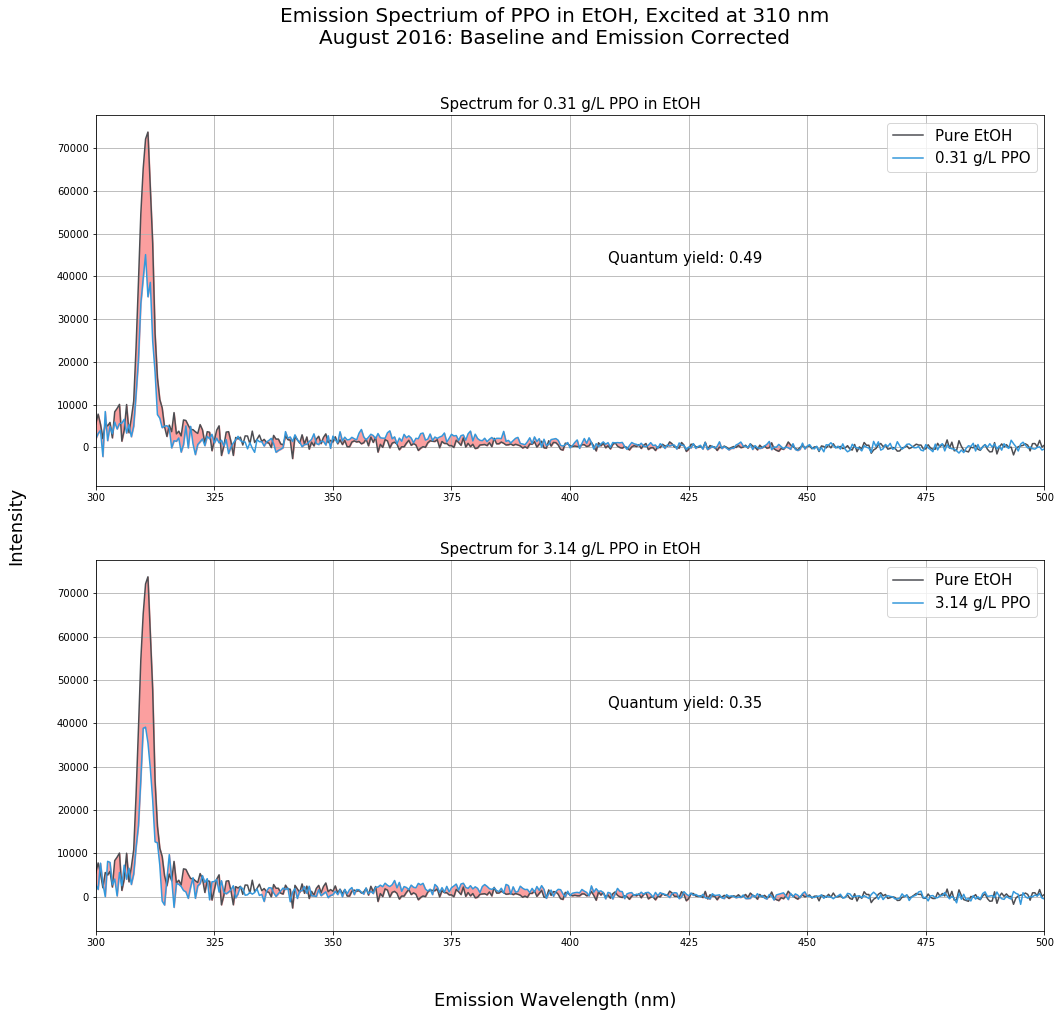

In [52]:
ranges_for_baseline = [[450,650]]

## Calculate the two quantum yields

# The integration ranges
QY_0x31_ex_range = [300,330]
QY_0x31_em_range = [335,450]
QY_3x14_ex_range = [300,330]
QY_3x14_em_range = [335,450]

fig = plt.figure(figsize=(17,15))
plt.suptitle("Emission Spectrium of PPO in EtOH, Excited at 310 nm\n"+
             "August 2016: Baseline and Emission Corrected",fontsize=20)

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0),sharex=ax1)

ax1 = calc_and_plot_QY(aug_2016_data[0], aug_2016_data[1], ranges_for_baseline, emcorr_quanta_sphere_values,
                       QY_0x31_ex_range, QY_0x31_em_range,
                       ax1,
                       blank_color = "#4c4d52", fluor_color = "#3498db", fill_color= "#fb9f9f",
                       QY_text_position = (0.54,0.6))
ax1.set_title("Spectrum for 0.31 g/L PPO in EtOH",fontsize=15)
ax1.legend(["Pure EtOH", "0.31 g/L PPO"],fontsize=15)

ax2 = calc_and_plot_QY(aug_2016_data[0], aug_2016_data[2], ranges_for_baseline, emcorr_quanta_sphere_values,
                       QY_3x14_ex_range, QY_3x14_em_range,
                       ax2,
                       blank_color = "#4c4d52", fluor_color = "#3498db", fill_color= "#fb9f9f",
                       QY_text_position = (0.54,0.6))
ax2.set_title("Spectrum for 3.14 g/L PPO in EtOH",fontsize=15)
ax2.legend(["Pure EtOH", "3.14 g/L PPO"],fontsize=15)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=18)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=18)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim([300,500])
plt.show()

The quantum yield calculation goes down when our concentration of PPO increases 10x. This result might be explained by the reabsorption of the emitted light due to the relatively high concentration of PPO. 

However, neither result is consistent with Lauren's $0.27 \pm 0.06$ result for PPO in EtOH. Furthermore, neither of the two agree with the "Accepted by Literature" result that she finds: $0.89 \pm 0.03$. We will see whether the measurements from June 2017 follow the same trends.

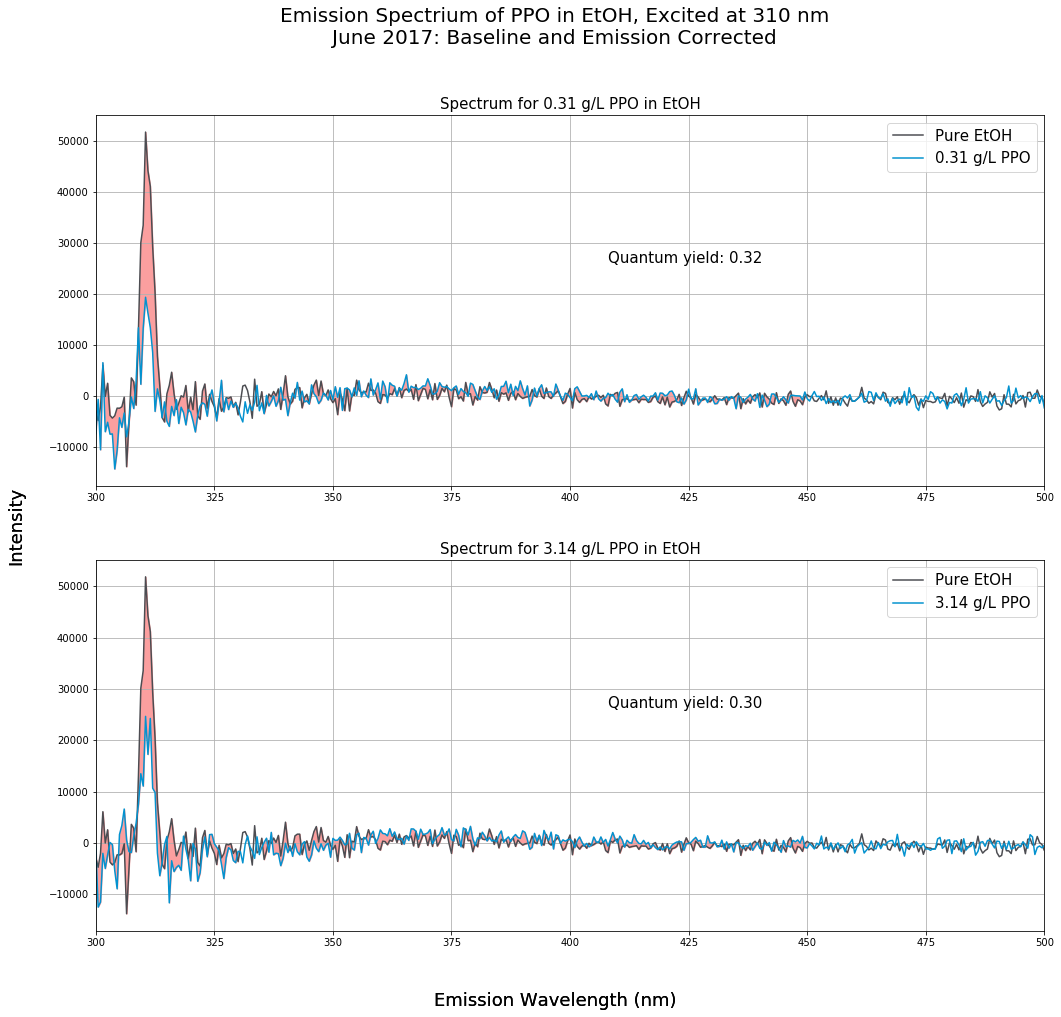

In [57]:
ranges_for_baseline = [[300,650]]

# The integration ranges
QY_0x31_ex_range = [300,330]
QY_0x31_em_range = [335,450]
QY_3x14_ex_range = [300,330]
QY_3x14_em_range = [335,450]

fig = plt.figure(figsize=(17,15))
plt.suptitle("Emission Spectrium of PPO in EtOH, Excited at 310 nm\n"+
             "June 2017: Baseline and Emission Corrected",fontsize=20)

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0))

ax1 = calc_and_plot_QY(jun_2017_data[0], jun_2017_data[1], ranges_for_baseline, emcorr_quanta_sphere_values,
                       QY_0x31_ex_range, QY_0x31_em_range,
                       ax1,
                       blank_color = "#4c4d52", fluor_color = "#0392cf", fill_color= "#fb9f9f",
                       QY_text_position = (0.54,0.6), QY_fontsize = 15)

ax1.set_title("Spectrum for 0.31 g/L PPO in EtOH",fontsize=15)
ax1.legend(["Pure EtOH", "0.31 g/L PPO"],fontsize=15)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=18)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=18)

ax2 = calc_and_plot_QY(jun_2017_data[0], jun_2017_data[2], ranges_for_baseline, emcorr_quanta_sphere_values,
                       QY_0x31_ex_range, QY_0x31_em_range,
                       ax2,
                       blank_color = "#4c4d52", fluor_color = "#0392cf", fill_color= "#fb9f9f",
                       QY_text_position = (0.54,0.6), QY_fontsize = 15)

ax2.set_title("Spectrum for 3.14 g/L PPO in EtOH",fontsize=15)
ax2.legend(["Pure EtOH", "3.14 g/L PPO"],fontsize=15)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=18)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=18)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim([300,500])

plt.show()

We only have one PPO sample for June 2016 at the appropriate slit width (as Mingfan's students have begun to use the FS). This preliminary result is a mixed indication. On one hand, it agrees with Lauren's calculated value. On the other, if conflicts with the QY calculations that were taken with the August data using the *same method*. 

From a visual comparison to the August data, the largest difference is that the emission spectra of the blank and the fluorophore sample overlap. This increased overlap causes the area between the two to decrease. Additionally, the negative values for the PPO emission spectrum on the interval [300, ~310] are negative, which would contribute to a lower quantum yield. Without the 3.14 g/L data available, it is difficult to determine the accuracy of these results. 

It should be possible to use the data collected with the large slit widths. This would allow us to have both concentrations of PPO. Although we could not directly compare these spectra with those of August (due to the differing intensities), the difference in intensity should be constant throughout this data series, so there should be no systematic error. 
